In [37]:
import pandas as pd
import darts
import seaborn as sns
import matplotlib.pyplot as plt
import os


# Hi-resolution Plots and Matplotlib inline
%config InlineBackend.figure_format = 'retina'

# "magic commands" to enable autoreload of your imported packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
data = pd.read_csv(f'../data/influenza_predictorECS.csv')

In [39]:
data

,Vaccination type,Event date,Date of birth,Event done at ID,Patient Count
0,Influenza Vaccine 1,25-Oct-2006,05-Aug-1961,C88069,1
1,Inactivated Influenza Vaccine (Split Virion) B...,25-Oct-2016,05-Aug-1961,E87750,1
2,Quadrivalent influenza vaccine Split Virion in...,15-Dec-2020,05-Aug-1961,E87750,1
3,Flucelvax Tetra (Seqirus UK) 1,14-Dec-2021,05-Aug-1961,E87750,1
4,Influenza Vaccine 1,10-Oct-2000,23-May-1990,B82609,1
...,...,...,...,...,...
6201,Cell-based quadrivalent Flu/Vac/SA inj 0.5ml p...,29-Oct-2022,04-Apr-1994,RQM,1
6202,Cell-based quadrivalent Flu/Vac/SA inj 0.5ml p...,10-Dec-2023,24-Sep-1994,RQM,1
6203,Influenza Vaccine 1,04-Oct-2023,14-May-1987,G84017,1
6204,Cell-based quadrivalent Flu/Vac/SA inj 0.5ml p...,30-Oct-2023,25-Nov-1990,Elsewhere,1


In [40]:
def process_dataframe(df):
    df.rename(
        columns={
            "Vaccination type": "vaccine",
            "Event date": "timestamp",
            "Patient ID": "pt_id",
            "Date of birth": "dob",
            "Event done at ID": "location",
            "Patient Count": "pt_count",
        },
        inplace=True,
    )
    df.dropna(subset="location", inplace=True)
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d-%b-%Y")
    df["dob"] = pd.to_datetime(df["dob"], format="%d-%b-%Y")
    df["age_at_vaccine"] = df["timestamp"].dt.year - df["dob"].dt.year
    df = df[df["age_at_vaccine"] > 0]
    return df

In [5]:
def update_location(df):
    most_frequent_location = df["location"].mode()[0]

    # Replace all other locations with 'Elsewhere'
    df["location"] = df["location"].apply(
        lambda x: x if x == most_frequent_location else "Elsewhere"
    )
    return df

In [6]:
def to_timeseries(df, column, time_period="M"):
    # Resample and count occurrences in each period
    m_count = df.resample(time_period, on=column).size()

    # Convert to DataFrame
    m_count_df = m_count.reset_index()

    # Rename columns
    m_count_df.columns = ["timestamp", "count"]

    return m_count_df

In [45]:
data = process_dataframe(data)

In [8]:
data = update_location(data)

/var/folders/0l/kzz8m3n52cs0d9lhcjh_yxqm0000gn/T/ipykernel_39739/3828458666.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["location"] = df["location"].apply(


In [9]:
data = to_timeseries(data, 'timestamp')

# TimeSeries Helper

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

class TimeSeriesHelper:
    def __init__(self):
        self.ts = None

    def to_timeseries(self, df, datetime_col, count_col, freq='D', agg_method='sum', date_format=None):
        """
        Convert DataFrame to time series.
        :param df: Pandas DataFrame containing the data.
        :param datetime_col: Name of the column with datetime data.
        :param count_col: Name of the column with count data.
        :param freq: Frequency for resampling ('D' for day, 'M' for month, 'Y' for year).
        :param agg_method: Method for aggregation (sum, mean, etc.).
        :param date_format: The format of the dates in the datetime_col.
        """
        # Convert the datetime column based on the specified format
        if date_format:
            df[datetime_col] = pd.to_datetime(df[datetime_col], format=date_format)
        else:
            df[datetime_col] = pd.to_datetime(df[datetime_col])
    
        # Set the datetime column as the index
        df.set_index(datetime_col, inplace=True)
    
        # Resample and aggregate
        if agg_method == 'sum':
            self.ts = df[count_col].resample(freq).sum()
        elif agg_method == 'mean':
            self.ts = df[count_col].resample(freq).mean()
        # More aggregation methods can be added here
    
        return self.ts
    
    def plot_timeseries(self, figsize=(10, 6), title='Time Series Plot', color='blue'):
        """
        Plot the time series with custom color.
        :param figsize: Size of the figure.
        :param title: Title of the plot.
        :param color: Color of the line plot.
        """
        if self.ts is not None:
            ax = self.ts.plot(kind='line', figsize=figsize, color=color)
            ax.set_xlabel('Date')
            ax.set_ylabel('Count')
            ax.set_title(title)
    
            # Rotate x-axis labels
            plt.xticks(rotation=45)
    
            # Remove the top, left, and right spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
    
            # Set gridlines
            ax.yaxis.grid(True)   # Horizontal grid
            ax.xaxis.grid(False)  # No vertical grid
    
            plt.show()
        else:
            print("No time series data available. Please run to_timeseries first.")
    
    def fill_missing(self, method='ffill'):
        """
        Fill missing values in time series.
        """
        if self.ts is not None:
            self.ts.fillna(method=method, inplace=True)
        else:
            print("No time series data available. Please run to_timeseries first.")
    
    def decompose_timeseries(self, model='additive', freq=None):
        """
        Decompose the time series.
        """
        if self.ts is not None:
            decomposition = seasonal_decompose(self.ts, model=model, period=freq)
            decomposition.plot()
            plt.show()
        else:
            print("No time series data available. Please run to_timeseries first.")


In [ ]:
# Example usage:
# ts_helper = TimeSeriesHelper()
# ts_helper.to_timeseries(df, 'datetime_col', 'count_col', 'M', 'mean')
# ts_helper.plot_timeseries(color='red')

In [88]:
data = pd.read_csv(f'../data/influenza_predictorECS.csv')

In [89]:
data = process_dataframe(data)

In [90]:
data.head(2)

,vaccine,timestamp,dob,location,pt_count,age_at_vaccine
0,Influenza Vaccine 1,2006-10-25,1961-08-05,C88069,1,45
1,Inactivated Influenza Vaccine (Split Virion) B...,2016-10-25,1961-08-05,E87750,1,55


In [91]:
# ts_helper = TimeSeriesHelper()
# ts_helper.to_timeseries(df, 'datetime_col', 'count_col', 'M', 'mean')
# ts_helper.fill_missing('bfill')
# ts_helper.plot_timeseries(figsize=(12, 8), title='Monthly Mean Count')
# ts_helper.decompose_timeseries(model='multiplicative', freq=12)

In [92]:
ts_helper = TimeSeriesHelper()

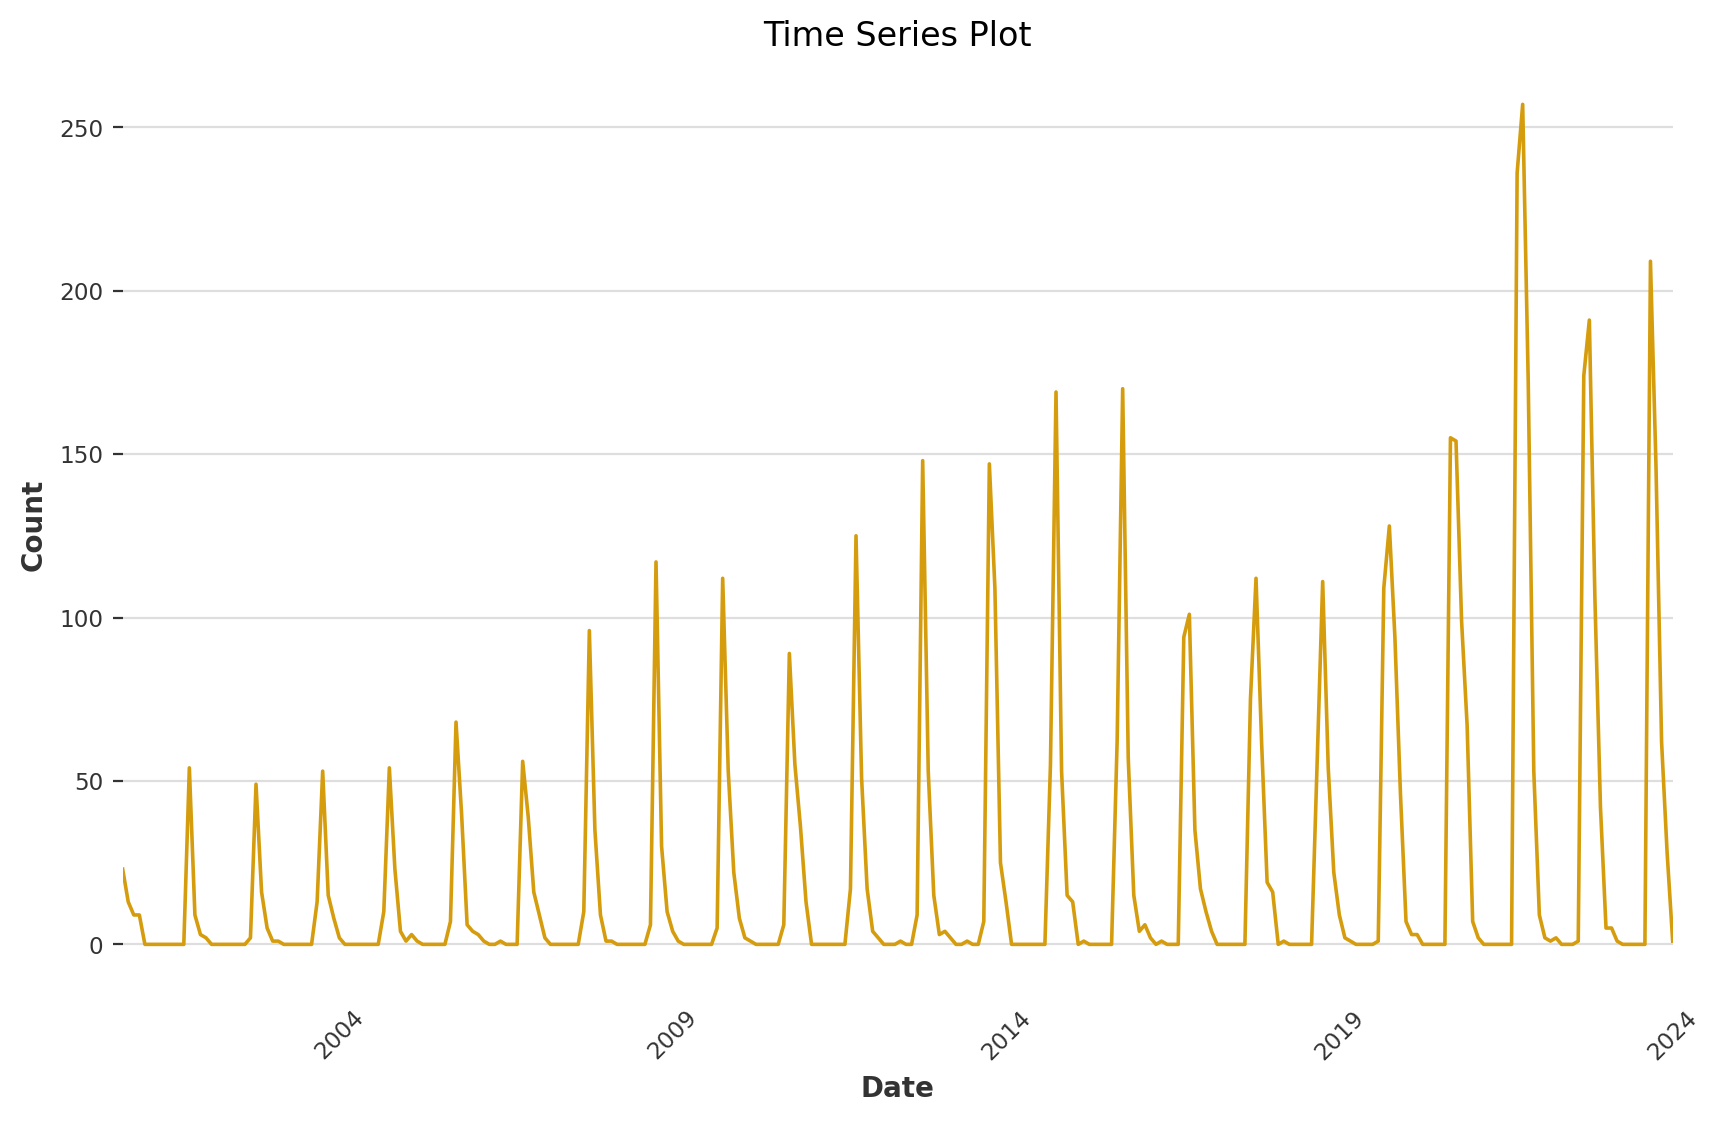

In [93]:
ts_helper.to_timeseries(data, 'timestamp', 'pt_count', 'M', 'sum')
ts_helper.plot_timeseries(color='#d59c0d')

In [56]:
ts_helper = TimeSeriesHelper()

In [58]:
ts_helper.to_timeseries(data, 'timestamp', 'pt_count', 'D')

KeyError: 'timestamp'

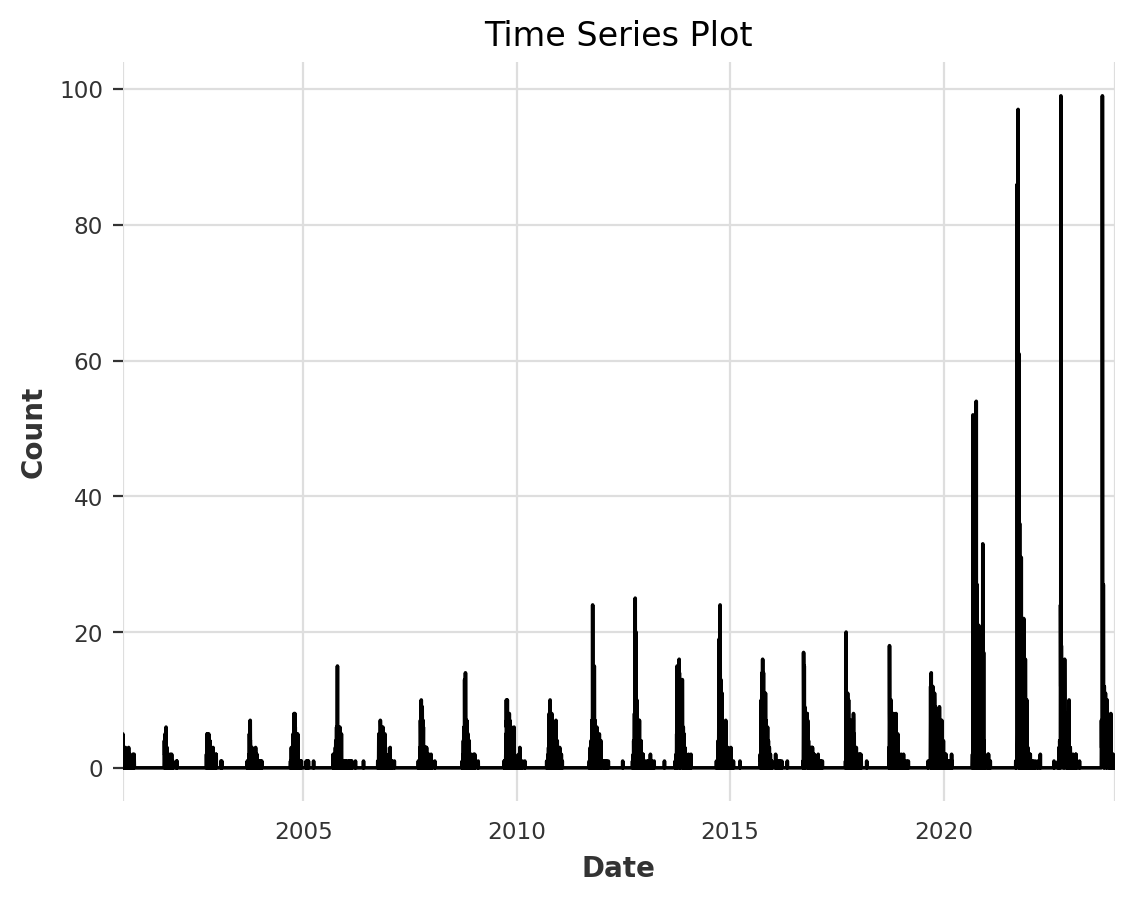

In [59]:
ts_helper.plot_timeseries()

In [10]:
data

,timestamp,count
0,2000-10-31,23
1,2000-11-30,13
2,2000-12-31,9
3,2001-01-31,9
4,2001-02-28,0
...,...,...
275,2023-09-30,209
276,2023-10-31,146
277,2023-11-30,62
278,2023-12-31,28


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  280 non-null    datetime64[ns]
 1   count      280 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.5 KB


In [12]:
data.set_index('timestamp', inplace=True)

In [13]:
data.reset_index(inplace=True)

In [14]:
data.head()

,timestamp,count
0,2000-10-31,23
1,2000-11-30,13
2,2000-12-31,9
3,2001-01-31,9
4,2001-02-28,0


In [15]:
import temporian as tp
# Convert the DataFrame into a Temporian EventSet
evset_signals = tp.from_pandas(data)

evset_signals

timestamp,count
2000-10-31 00:00:00+00:00,23
2000-11-30 00:00:00+00:00,13
2000-12-31 00:00:00+00:00,9
2001-01-31 00:00:00+00:00,9
2001-02-28 00:00:00+00:00,0
…,…


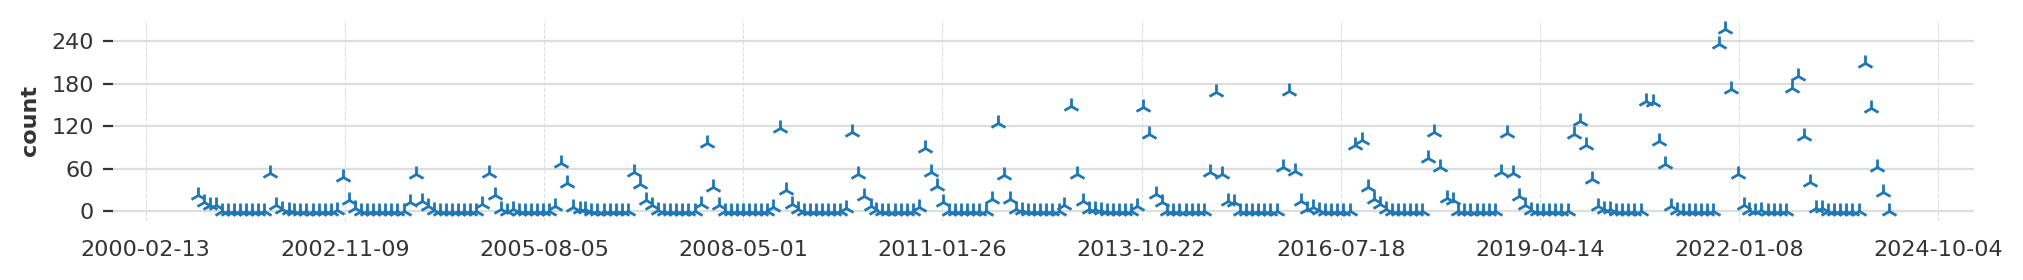

In [16]:
_ = evset_signals.plot()

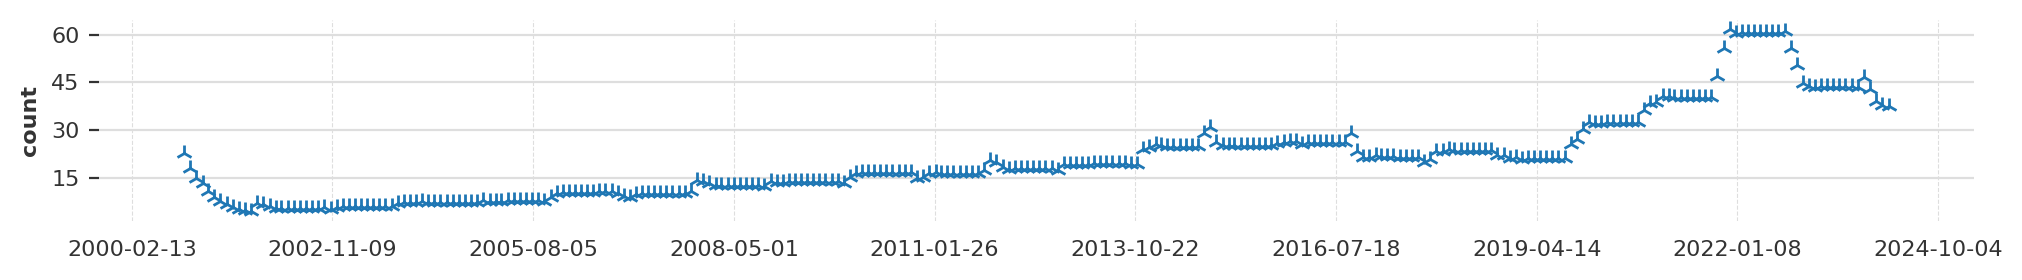

In [23]:
# Pick only one feature
signal = evset_signals["count"].cast(tp.float32)

# Moving avg
trend = signal.simple_moving_average(tp.duration.weeks(52))
trend.plot()

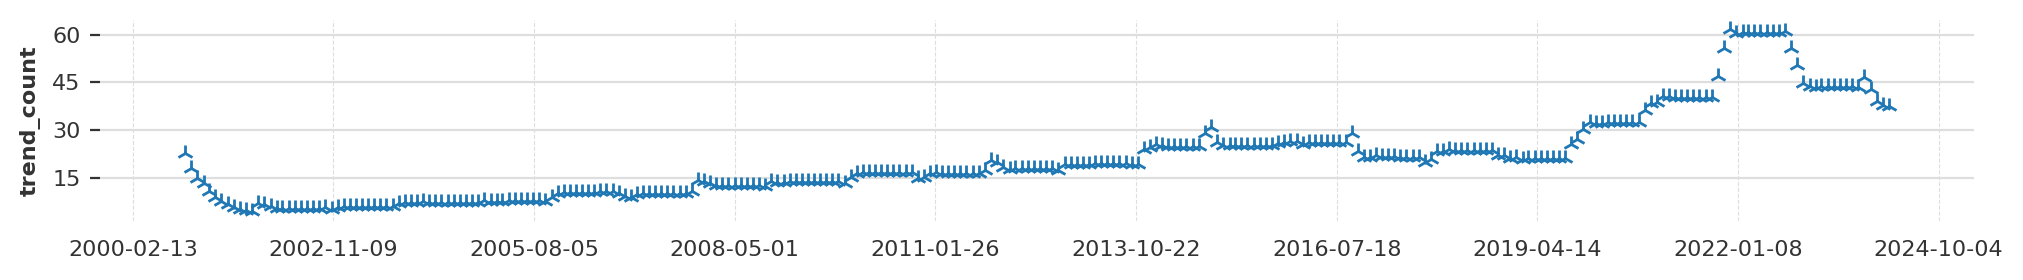

In [24]:
# Let's rename the feature by adding a prefix
trend = trend.prefix("trend_")
trend.plot()

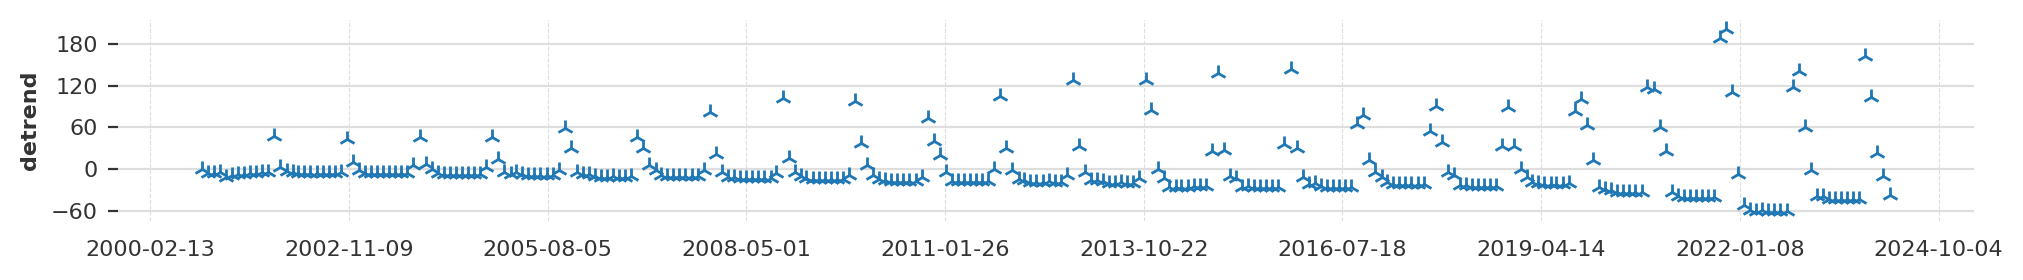

In [25]:
# Remove the slow 'trend' to get 'season'
detrend = signal - trend

# Rename resulting feature
detrend = detrend.rename("detrend")

detrend.plot()

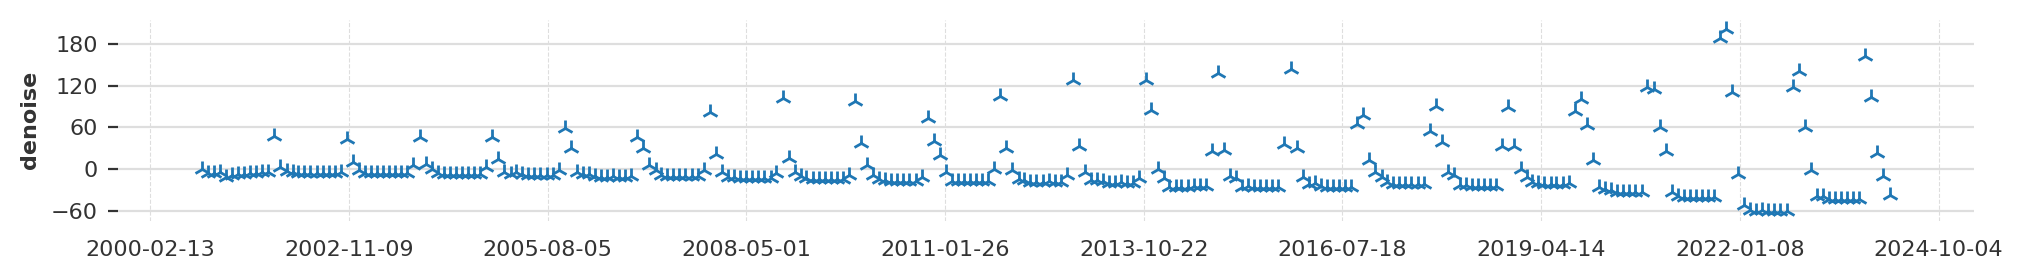

In [27]:
denoise = detrend.simple_moving_average(tp.duration.days(1)).rename("denoise")
denoise.plot()

In [29]:
!pip3 install bokeh -q

In [31]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

# Enable the display of Bokeh plots in Jupyter Notebook
output_notebook()

# Generating artificial data
np.random.seed(42)  # For reproducibility
dates = pd.date_range('2023-01-01', periods=100)
data = np.random.randn(100).cumsum()

# Creating a DataFrame
df = pd.DataFrame({'Date': dates, 'Value': data})

plot = figure(title='Example Bokeh Plot',
              x_axis_label='Date',
              y_axis_label='Value',
              x_axis_type='datetime',
              width=800,  # Changed from plot_width
              height=400)  # Changed from plot_height

# Adding a line plot
plot.line(df['Date'], df['Value'], legend_label='Random Data', line_width=2)

# Show the plot
show(plot)


Loading BokehJS ...

In [36]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import numpy as np

# Enable the display of Bokeh plots in Jupyter Notebook
output_notebook()

# Generate artificial data
data = np.random.normal(0, 0.5, 1000)

# Create a histogram
hist, edges = np.histogram(data, bins=50)

# Create a Bokeh plot
p = figure(title="Histogram", background_fill_color="#ffffff")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color="#d59c0d", line_color="#62899f")

# Show the plot
show(p)

Loading BokehJS ...